<a href="https://colab.research.google.com/github/Divs1159/Reinforcement/blob/main/doc/tutorials/FrozenLake_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 40.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=d53989335157d46b4454f5f81f17780693d2abdc79c492541ba105e4f38666ca
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
# Rendering Dependencies
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# Gym Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

  Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


# **Lets Begin**

The goal of this article is to teach an AI how to solve the ❄️Frozen Lake environment using reinforcement learning. We will using Q-learning Algorithm.

In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gym.wrappers.record_video import RecordVideo
import torch
import time
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [3]:
#The following code is for rendering on Colab. Do not need this for Jupyter notebook

import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

# Google Colab needs to render the environment to a virtual display
# we will record this as a video and play it after the training has finished
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
env.reset()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video(mp4_filename):
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    if mp4_filename:
      print(mp4)
      mp4 = mp4_filename

    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [4]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

env = gym.make('FrozenLakeNotSlippery-v0')

# Instantiate the Environment.
# env = gym.make('FrozenLake-v0')

# To check all environments present in OpenAI
# print(envs.registry.all())

env = RecordVideo(env, './video_new',  episode_trigger = lambda episode_number: True)
env.reset()
show_video('video_new/rl-video-episode-0.mp4')  #only shows the last run

video/rl-video-episode-0.mp4


# Understanding the Environment

In❄️Frozen Lake, there are 16 tiles, which means our agent can be found in 16 different positions, called states. For each state, there are 4 possible actions: go ◀️LEFT, 🔽DOWN, ▶️RIGHT, and 🔼UP. Learning how to play Frozen Lake is like learning which action you should choose in every state. To know which action is the best in a given state, we would like to assign a quality value to our actions. We have 16 states and 4 actions, so want to calculate 16 x 4 = 64 values.

In [7]:
environment = gym.make("FrozenLake-v1", is_slippery=False)
environment.reset()
environment.render()

# Our table has the following dimensions:
# (rows x columns) = (states x actions) = (16 x 4)
qtable = np.zeros((16, 4))

# Alternatively, the gym library can also directly g
# give us the number of states and actions using
# "env.observation_space.n" and "env.action_space.n"
nb_states = environment.observation_space.n  # = 16
nb_actions = environment.action_space.n      # = 4
qtable = np.zeros((nb_states, nb_actions))

# Let's see how it looks
print('Q-table =')
print(qtable)

Q-table =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Great! We have our Q-table with 16 rows (our 16 states) and 4 columns (our 4 actions) as expected.

In [8]:
random.choice(["LEFT", "DOWN", "RIGHT", "UP"])

'RIGHT'

Remember, only one state can give us a positive reward in the entire game. How are we supposed to take the right directions at the very beginning when the only validation we have is at the very end? If we ever want to see a reward of 1, we’d need to be lucky enough to find the correct sequence of actions by chance. Unfortunately, that’s exactly how it works… the Q-table will remain filled with zeros until the agent randomly reaches the goal G.

# **Q-learning**

Let’s go back to our problem. Okay, we need to be lucky enough to find the goal G by accident. But once it’s done, how to backpropagate the information to the initial state? The Q-learning algorithm offers a clever solution to this issue. We need to update the value of our state-action pairs (each cell in the Q-table) considering 1/ the reward for reaching the next state, and 2/ the highest possible value in the next state.

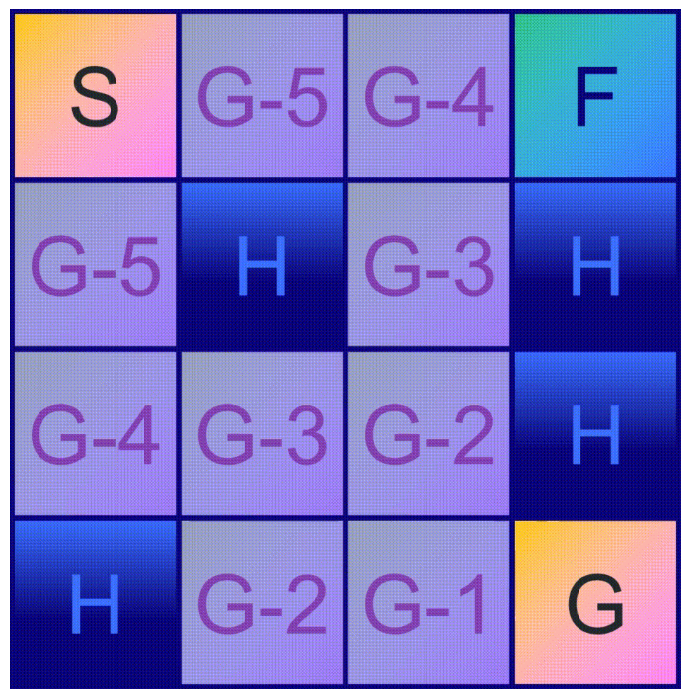

We know we get a reward of 1 when we move to G. As we just said, the value of the state next to G (let’s call it G-1) with the relevant action to reach G is increased thanks to the reward. Okay good, end of the episode: the agent won and we restart the game. Now, the next time the agent is in a state next to G-1, it will increase the value of this state (let’s call it G-2) with the relevant action to reach G-1. The next time the agent is in a state next to G-2, it will do the same. Rinse and repeat, until the update reaches the initial state S.

Q(sₜ, aₜ) is a cell in our Q-table, corresponding to the row number sₜ and the column number aₜ: we need to update it using 1/ the reward for the next state (formally noted rₜ), and 2/ the maximum possible value in the next state (maxₐQ(sₜ₊₁, a)). Therefore, the update formula must look like:

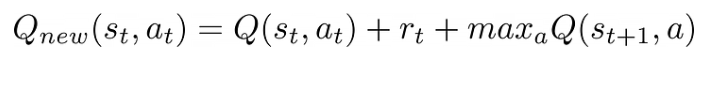

The new value is the current one + the reward + the highest value in the next state.

So training our agent in code means:

1. Choosing a random action (using action_space.sample()) if the values in the current state are just zeros. Otherwise, we take the action with the highest value in the current state with the function np.argmax();

2. Implementing this action by moving in the desired direction with step(action);


3. Updating the value of the original state with the action we took, using information about the new state and the reward given by step(action);

We keep repeating these 3 steps until the agent gets stuck in a hole or reaches the goal G. When it happens, we just restart the environment with reset() and start a new episode until we hit 1,000 episodes.

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.      0.59049 0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.6561  0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.729   0.     ]
 [0.      0.81    0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.9     0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      0.     ]]


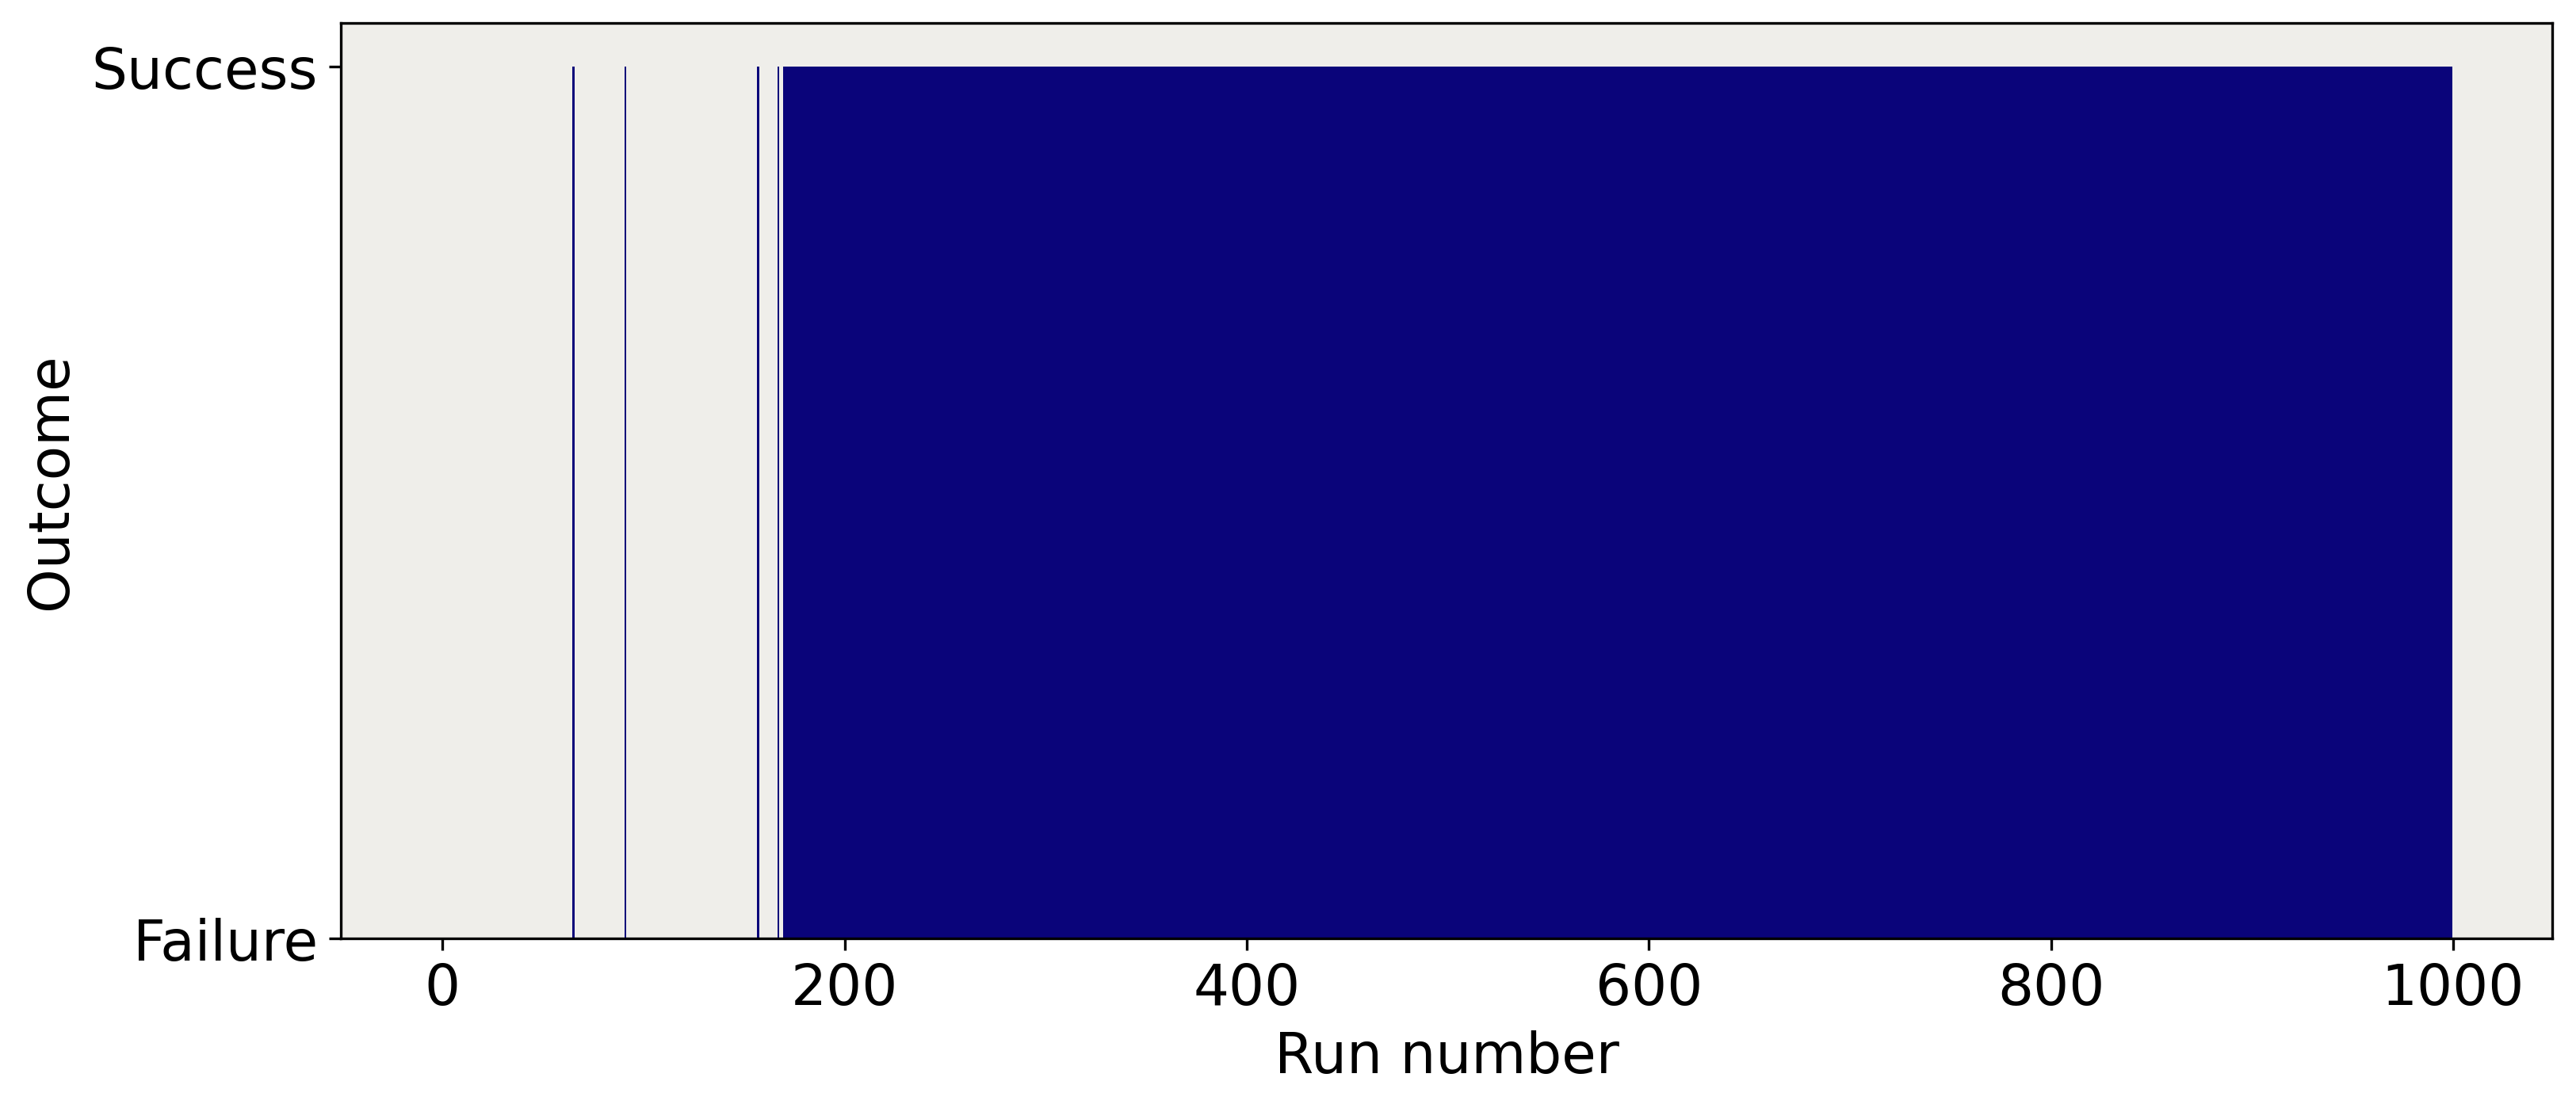

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 17})

# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000        # Total number of episodes
alpha = 0.5            # Learning rate
gamma = 0.9            # Discount factor

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

# Training
for _ in range(episodes):
    state = environment.reset()
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
          action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
          action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
          outcomes[-1] = "Success"

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

In [16]:
episodes = 100
nb_success = 0

environment = gym.make('FrozenLakeNotSlippery-v0')
environment = RecordVideo(environment, './video_new',  episode_trigger = lambda episode_number: True)
environment.reset()


# Evaluation
for _ in range(100):
    state = environment.reset()
    done = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
          action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
          action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print (f"Success rate = {nb_success/episodes*100}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Success rate = 100.0%


In [17]:
show_video('video_new/rl-video-episode-0.mp4')

video/rl-video-episode-0.mp4
